In [16]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import sys
import numpy as np
import pandas as pd
import scipy.spatial.distance as distance
import scipy.spatial as spatial
import scipy.integrate as integrate
import scipy.special as special
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from pypdevs.infinity import INFINITY

# Import code for DEVS model representation:
from pypdevs.DEVS import *

# Model parameters
class Parameters:
    TOPOLOGY_FILE = "topology/lattice.adj"
    CULTURE_LENGTH = 5
    FASHION_RATE = 0.5
    TRAITS = 5

# This is a polimorphic class for the enumeration. Do not change.
def enum(**kwargs):
    class Enum(object): pass
    obj = Enum()
    obj.__dict__.update(kwargs)
    return obj

# An agent can be propagating its state or just running Axelrod's behavior
ActionState = enum(P='PROPAGATING', N="NORMAL")

# Properties that can be asked to the coupled model
ENVProps = enum(NUMBER_OF_CULTURES='agent_states', FASHION='fashion')

# Agent state clsas
class AgentState(object):
    def __init__(self, name, id):
        # The agent has a name, the current time, the time advance value, its culture sampled from a random distribution
        # the neighboring states and the action, either propagate or workmode.
        self._name = name
        self.current_time = 0.0
        self.id = id 
        self.ta = 0

        self.culture = [np.random.randint(1, Parameters.TRAITS) for i in range(Parameters.CULTURE_LENGTH)] 
        self.neighbors_culture = {} 
        self.action_state = ActionState.P 

    # to string method
    def __repr__(self):
        return "Agent: %s, culture: %s" % (str(self.name), str(self.culture))

# Atomic agent that logs the number of cultures
class LogAgent(AtomicDEVS):
    def __init__(self):
        self.set_values()
        self.stats = []
        self.name='logAgent'
        self.ta = 1
        self.state = "LogAgent"
        self.current_time = 0 
        self.elapsed = 0 
        self.my_input = {}

    def __lt__(self, other):
        return self.name < other.name 

    # Save the number of cultures to the stats array
    def saveLoginfo(self): 
        number_of_cultures = self.parent.getContextInformation(ENVProps.NUMBER_OF_CULTURES)
        stats = (self.current_time, number_of_cultures)
        self.stats.append(stats) 

    # The internal transition logs the agent's stats
    def intTransition(self):
        self.current_time += self.ta
        self.saveLoginfo()

    def timeAdvance(self):
        return self.ta

    def set_values(self):
        self.ta = 1 #0.1

# The Agent class
class Agent(AtomicDEVS):
    def __init__(self, name=None, id=None, kwargs=None):
        AtomicDEVS.__init__(self, name)
        self.elapsed = 0  # Start the elapsed time in 0
        self.in_event = self.addInPort("in_event")  # Add an input port for all the connections
        self.state = AgentState(name=name, id=id)  # The state instance
        self.in_ports_dict = {}
        self.out_ports_dict = {}

        self.y_up = (self.state.id, self.state.culture)

    # Add a  connection towards an agent with id ag_id
    def add_connections(self, ag_id): 
        inport = self.addInPort(name=ag_id)
        self.in_ports_dict[ag_id] = inport
        outport = self.addOutPort(name=ag_id)
        self.out_ports_dict[ag_id] = outport
        return inport, outport

    # Calculate the similarity function basedon the average similar traits
    def similarity_with(self, neighbor_culture):
        return sum(np.array(neighbor_culture) == np.array(self.state.culture))/float(len(self.state.culture))

    # Mix culture by randomly selecting a different culture
    def mix_culture(self, neighbor_culture):
        same_culture_index = np.array(neighbor_culture) != np.array(self.state.culture)
        indexes = np.where(same_culture_index == True)
        rand_cult = np.random.choice(indexes[0], 1)[0]
        self.state.culture[rand_cult] = neighbor_culture[rand_cult]

    # Pick a random neighbor
    def get_neighbor(self):
        neighbor_key = np.random.choice(list(self.state.neighbors_culture.keys()), 1)[0]
        neighbor_culture = self.state.neighbors_culture[neighbor_key]
        return neighbor_culture

    # Update the neighbors culture upon message reception
    def extTransition(self, inputs): 
        self.state.current_time += self.elapsed
        for k, v in inputs.items(): 
            self.state.neighbors_culture[k.name] = v
        return self.state

    # Agents internal transition drives the cultural mix. 
    def intTransition(self):
        # Update the current simulation time
        self.state.current_time += self.state.ta 
        # Empty the upward causation message 
        self.y_up = None
        # If the stat has already been propagated switch to normal mode and set the y_up message
        if self.state.action_state == ActionState.P:
            self.state.action_state = ActionState.N
            self.y_up = (self.state.id, self.state.culture)
        else:
            # In normal mode toss a coin for the FASHION_RATE behavior
            toss = np.random.random()

            if toss > Parameters.FASHION_RATE:
                # Axelrod's normal behavior
                # Select a random neighbor
                neighbor_culture = self.get_neighbor()
                similarity = self.similarity_with(neighbor_culture)
                # If similar, mix their cultures
                if similarity < 1 and np.random.random() < similarity:
                    self.mix_culture(neighbor_culture)
                    self.state.action_state = ActionState.P
            else:
                # Fashion behavior, get a random feature and its most observed value from the coupled model
                # The macro level state is a stochastic variable sampling fashion values
                feature, fashion = self.parent.getContextInformation(ENVProps.FASHION)
                self.state.culture[feature] = fashion
        return self.state

    def __lt__(self, other):
        return self.name < other.name 

    def outputFnc(self):
        # Output function to share the culture with the neighbors
        ret = {}
        if self.state.action_state == ActionState.P:
            for outport in self.out_ports_dict.values():
                ret[outport] = self.state.culture 

        return ret

    def timeAdvance(self):
        # If propagating make an instantaneous transition
        ta = 0
        if self.state.action_state == ActionState.P:
            ta = 0
        # Else, transition with constant time step = 1
        elif self.state.action_state == ActionState.N:
            ta = 1 
        self.state.ta = ta
        return self.state.ta


# The couple dmodel
class Environment(CoupledDEVS):
    def __init__(self, name=None):
        """
        A simple flocking system consisting
        """
        # Always call parent class' constructor FIRST:
        CoupledDEVS.__init__(self, name)
        # Create an empty graph for the communication channels
        self.G = nx.Graph()

        # Children states initialization, read the topology file, create N agents and connect the agents.
        self.create_topology() 

        # Instance of the LogAgent
        log_agent = LogAgent()
        log_agent.OPorts = []
        log_agent.IPorts = []
        self.addSubModel(log_agent)
        self.agents[-1] = log_agent
        log_agent.saveLoginfo()

    # Create the Atomic agents and the internal coupling network based on the topology file adjency matrix
    def create_topology(self):
        G = nx.read_adjlist(Parameters.TOPOLOGY_FILE)
        self.agents = {}
        for i, node in G.nodes(data=True): 
            ag_id = int(i)
            agent = Agent(name="agent %s" % i, id=ag_id, kwargs=node) 
            self.agents[ag_id] = self.addSubModel(agent)
            self.G.add_node(agent.state.id)

        for i in G.edges():
            if i[0] == i[1]: continue
            ind0 = int(i[0])
            ind1 = int(i[1])
            a0 = self.agents[ind0]
            a1 = self.agents[ind1]
            
            i0, o0 = a0.add_connections(ind1)
            i1, o1 = a1.add_connections(ind0)

            self.connectPorts(o0, i1)
            self.connectPorts(o1, i0)

        self.cultures = {}

    # Update the cultures dictionary on reception of upward causation events
    def globalTransition(self, e_g, x_b_micro, *args, **kwargs):
        super(Environment, self).globalTransition(e_g, x_b_micro, *args, **kwargs)
        # Update the cultures dictionary
        self.cultures.update(x_b_micro)

    # This function implements the V_down downward information mechanism.
    def getContextInformation(self, property, *args, **kwargs):
        super(Environment, self).getContextInformation(property)
        # Count the number of unique cultures in the system
        if(property == ENVProps.NUMBER_OF_CULTURES):
            unique_cultures = []
            if self.cultures:
                unique_cultures = np.unique(np.array(list(self.cultures.values())), axis=0) 
            return len(unique_cultures)

        if(property == ENVProps.FASHION):
            # Get a random feature
            mat = np.array(list(self.cultures.values()))
            randind = np.random.randint(Parameters.CULTURE_LENGTH)
            feature = mat[:, randind]
            # Return the most observed value
            fashion_value = np.bincount(feature).argmax()
            return randind, fashion_value

    # Select function
    def select(self, immChildren):
        """
        Choose a model to transition from all possible models.
        """
        # Doesn't really matter, as they don't influence each other
        return immChildren[0]


In [5]:
from pypdevs.simulator import Simulator
import itertools
import os
import pandas as pd
import tqdm
import networkx as nx
import fileinput
import tempfile
import fnmatch
import shutil
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


def run_single(duration, retry=0):
    environ = Environment(name='Env')
    sim = Simulator(environ)
    sim.setTerminationTime(duration)
    sim.setClassicDEVS()
    sim.simulate()
    dataframe = pd.DataFrame(environ.agents[-1].stats)
    dataframe['retry'] = retry
    dataframe['Fashion Rate'] = Parameters.FASHION_RATE
    output_columns = ['Time', 'Number of Cultures',  'retry', 'Fashion Rate']
    dataframe.columns = output_columns 
    return dataframe

def plot(data):
    SMALL_SIZE = 12
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  
    filtered_data = data[(data.Time % 10 == 0)]
    plt.figure(figsize=(12,8))

    ax = sns.pointplot(x="Time", y="Number of Cultures", data=filtered_data,
            ci="sd", capsize=.2, dodge=True, hue='Fashion Rate')

    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 10 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

    return ax



def run_multiple_retries(retries=1, duration=10000, fashions=[0 , 0.25, 0.5, 0.75, 1]):
    dfs = []
    for i, fashion_rate in tqdm.tqdm(list(itertools.product(range(retries), fashions))):
        Parameters.FASHION_RATE = fashion_rate
        dfs.append(run_single(retry=i, duration=duration))
    return pd.concat(dfs)


In [17]:
Parameters.TOPOLOGY_FILE = 'topology/lattice.adj'
Parameters.CULTURE_LENGTH = 5
Parameters.FASHION_RATE = 0.0
Parameters.TRAITS = 10

<AxesSubplot:xlabel='Time', ylabel='Number of Cultures'>

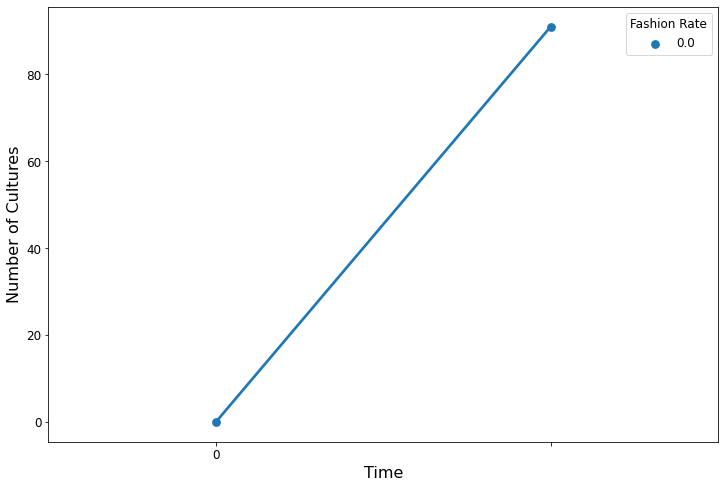

In [18]:
df = run_single(duration=10)
plot(df)

In [13]:
Parameters.TOPOLOGY_FILE = 'topology/grafo_muy_grande'
Parameters.FASHION_RATE = 0
df = run_single(10, 10)
plot(df)

KeyboardInterrupt: 

In [8]:
data = run_multiple_retries(duration=100, retries=3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:47<00:00,  3.16s/it]


<AxesSubplot:xlabel='Time', ylabel='Number of Cultures'>

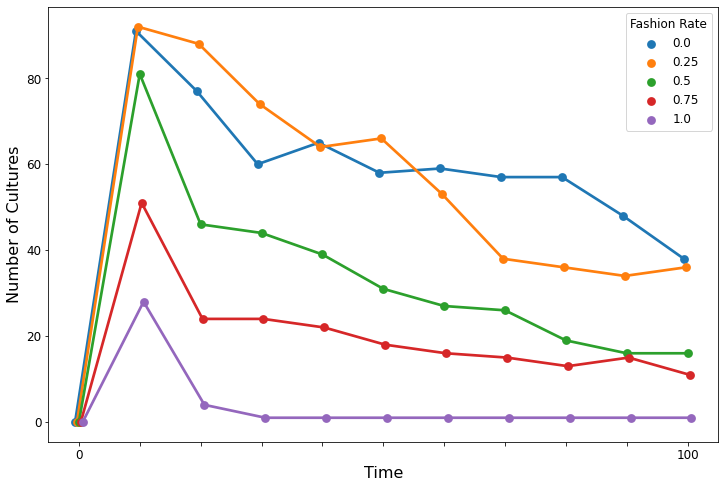

In [5]:
plot(data)